# Word embeddings with Word2Vec

Frequency as well as dictionary based approaches from the previous chapters ignore semantic relationships between the words in the document. Just recording word frequencies will not allow us to understand the meaning of textual information. In addition, we also mentioned that these models may also be negatively impacted by numerical issues arising from high dimensionality and sparsity of word vectors.

Due to these limitations we are going to take a look at statistical language models which aim to learn embeddings for words and documents that capture semantic meaning. An embedding is a collection of numerical values that represent a word or document, i.e., usually a real-valued vector. The useful characteristic of these models is that words or documents with similar semantic meaning will have a similar numerical representation. If you hear about this concept for the first time, you may wonder why one should represent words by vectors and how it makes sense that words with similar meaning have similar vectors. Thus, let us take a look at a meaningful example. The scatter plot below visualizes different dog breeds w.r.t. their weight and size. Assuming, we only use these two metrics to characterize different dog breeds, the breed "Airedale Terrier" is represented by the vector 

$$
\boldsymbol{x}^{(\text{Airedale})} = 
\begin{pmatrix}
22.5 \\
58.5 \\
\end{pmatrix}
$$

so this is how you may picture how a word is transformed into a vector. Furthermore, if you scroll over the points in the scatter plot, you may observe that breeds with similar characteristics have similar vectors (vectors that are close to each other), so this is how you may picture how words with similar meaning may have similar vectors. Furthermore, by transforming dog breeds into vectors, we could use vector calculus to derive new insights. For instance, we can calculate the average vector of certain dog breeds to determine a representative embedding for this group of breeds. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import plotly.express as px

# https://tarigs.com/size-table-dog/
dog_breeds_2d = pd.read_csv("../data/dog_breeds.csv")
dog_breeds_2d.set_index("breed", inplace = True, drop = True)
dog_breeds_2d.dropna(inplace = True)
dog_breeds_2d.head()

,weight,size
breed,,
Afghan hound,25.0,68.5
Airedale Terrier,22.5,58.5
American Staffordshire Terrier,16.0,45.5
Australian Shepherd,24.0,52.0
Borzoi,36.0,76.5


In [2]:
# hover over each point to examine the dog breed
fig = px.scatter(dog_breeds_2d, x = "weight", y = "size", hover_name = dog_breeds_2d.index, width = 800, height = 600, title = "Dog breed vectorization")
fig.show()

As the dog breeds are represented by vectors now we can, e.g., quantify their similarity be euclidean distance.

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

# determine all pairwise euclidean distances
pairwise_distances = pd.DataFrame(euclidean_distances(dog_breeds_2d), index = dog_breeds_2d.index, columns = dog_breeds_2d.index)
pairwise_distances.iloc[:5, :5]

breed,Afghan hound,Airedale Terrier,American Staffordshire Terrier,Australian Shepherd,Borzoi
breed,,,,,
Afghan hound,0.000000,10.307764,24.698178,16.530275,13.601471
Airedale Terrier,10.307764,0.000000,14.534442,6.670832,22.500000
American Staffordshire Terrier,24.698178,14.534442,0.000000,10.307764,36.891733
Australian Shepherd,16.530275,6.670832,10.307764,0.000000,27.280946
Borzoi,13.601471,22.500000,36.891733,27.280946,0.000000


For instance, which is the most similar breed to the American Staffordshire Terrier if we identify it the closest euclidean distance

In [4]:
breed_name = "American Staffordshire Terrier"
pairwise_distances.columns[np.argsort(pairwise_distances.loc[breed_name].values)[1]]

'Standard Schnauzers'

We can determine the average of two breed vectors and look for the most similar dog breed to this vector.

In [5]:
bullterier_vector = (dog_breeds_2d.loc["Staffordshire Bullterrier"] + dog_breeds_2d.loc["Bull terrier"]).divide(2)
pairwise_distances.columns[np.argsort(euclidean_distances(bullterier_vector.values.reshape(1, -1), dog_breeds_2d.values))[0][0]]

'American Staffordshire Terrier'

This example is only meant to give you an idea that vector representations of words may not be as abstract is it may sound in the first place. However, if we want to extend this idea to a more general scenario, we are going to make use of other numbers than attributes of the word. In our example this has been the size and the weight of a dog breed, obviously, not every word is associated with object that have meaningful size and weight characteristics, e.g., the word elegant. Furthermore, we may need more than just two numbers to capture semantic meaning. 

## Word2Vec

A popular model which is able to learn word vectors (also called word embeddings) which capture semantic and syntactic meaning is Word2Vec. It is build upon a neural network architecture and has been presented by [Mikolov et al. (2013)](https://arxiv.org/abs/1301.3781) and [Mikolov et al. (2013)](https://arxiv.org/abs/1310.4546). The model represents every word by a $p$-dimensional vector. In comparison to our example, each real-valued number in a word vector does not have a specific meaning. However, after the model is trained, the vectors will be similar to each other if the words have similar meaning. Two versions of the Word2Vec model exist: (1) the continuous bag of words approach (CBOW), and, (2) the skip-gram (SG) model. For both approaches, we take a look at the surrounding words around a center word. Let us denote $w_j$ as the center word. The surrounding words, we may also call then feature words, are defined by the window size whose length $2 \cdot t$ needs to be chosen by the user. The feature words are up to $t$ words to the left and up to $t$ words to the right of the center word: $w_{j-t}, w_{j-t+1}, ..., w_{j-1}, w_{j+1}, w_{j + t -1}, w_{j + t}$. For instance, given the sentence, "the dog would like a piece of the sandwich", setting the center word "like" and a window size of $4$, the context words are: "dog, would, a, piece". The CBOW model tries to predict the center word by the feature words, the SG model tries to predict feature words, given the center word. 

The easiest way to understand the model is to take a look at a minimal example. So, let's go: First, everything starts with a corpus. Ours consists of three sentences:


In [6]:
from gensim.utils import simple_preprocess

raw_corpus = [
    "I love vanilla ice cream",
    "I love strawberry ice cream",
    "The capitol of Germany is Berlin",
    "The capitol of France is Paris"
]

corpus = [simple_preprocess(doc, min_len = 1) for doc in raw_corpus]
corpus

[['i', 'love', 'vanilla', 'ice', 'cream'],
 ['i', 'love', 'strawberry', 'ice', 'cream'],
 ['the', 'capitol', 'of', 'germany', 'is', 'berlin'],
 ['the', 'capitol', 'of', 'france', 'is', 'paris']]

Next, we build a vocabulary in which each word is mapped to an index.

In [7]:
word2index = dict()
idx = 0
for doc in corpus:
    for word in doc:
        if word in word2index.keys():
            continue
        else:
            word2index[word] = idx
            idx += 1

word2index

{'i': 0,
 'love': 1,
 'vanilla': 2,
 'ice': 3,
 'cream': 4,
 'strawberry': 5,
 'the': 6,
 'capitol': 7,
 'of': 8,
 'germany': 9,
 'is': 10,
 'berlin': 11,
 'france': 12,
 'paris': 13}

### CBOW

The CBOW model is build around a multi-class classification task. One predicts the probabilities for the center word, given the words within the window size: $P \left( w_i | w_{i-t}, w_{i-t+1}, ..., w_{i-1}, w_{i+1}, w_{i + t -1}, w_{i + t} \right) $. Let us denote $\boldsymbol{x}_{j}$ as the one-hot encoded vector for word $j$ where $j$ is the number of the index in the dictionary. The number of categories is equal to the number of words, e.g., $d = 16$. To generate probability predictions, we make use of two matrices $\boldsymbol{W}, \boldsymbol{V}$ whose elements are parameters which need to be trained. Assume a window size of $2$ (so one word to the left and one word to the right) and we start with the sequence "I love vanilla". The feature words and their one-hot encoded vectors, e.g., "I", "vanilla" is represented by $\boldsymbol{x}_{0}, \boldsymbol{x}_{2}$ which can be subsumed in a matrix:

$$\boldsymbol{C}^{(0, 2)} = \begin{pmatrix} \boldsymbol{x}_{0} \\ \boldsymbol{x}_{2} \end{pmatrix}$$

See in the cell below how this looks like for our example:

In [8]:
from torch.nn.functional import one_hot
import torch

# define the number of terms in the lexicon
d = len(word2index.keys())

C_02 = one_hot(torch.LongTensor([0, 2]), num_classes=d)
C_02

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Next, we multiply this matrix with the context word embedding matrix $\boldsymbol{W}$, its first dimension must be equal to $d$, its second dimension $p$ can be set by the user and will define the dimension of word embeddings. Let us set $p=3$ for our example and take a look at an example below whose parameters have been randomly initialized.

In [9]:
# embedding dimension
p = 3

W = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
W.weight

Parameter containing:
tensor([[ 0.9039,  0.6536,  0.9262],
        [ 0.2919, -0.6739,  0.9358],
        [ 0.2579,  1.0729, -0.1822],
        [ 0.6497, -1.3003, -0.0568],
        [ 0.7587, -0.7188, -0.7877],
        [ 0.5661, -0.5250, -0.4199],
        [-0.5949,  1.7023, -1.6629],
        [ 1.0525,  0.4110,  0.0566],
        [ 2.4131,  0.8462,  0.0938],
        [ 2.2301, -0.4125,  1.5776],
        [ 0.3598, -0.0321,  0.1563],
        [ 0.2093, -0.4351, -1.3715],
        [ 0.9007,  0.0039, -1.2574],
        [ 0.9018, -0.7630,  0.2781]], requires_grad=True)

This can be seen as the weights from the first layer in a neural network whose input are the one-hot context word vectors with dimension $2t \times d$. Each row of this matrix relates to the word embedding for one word if it is used in the window of a center word. Multiplying the one-hot vector input with this matrix basically transforms the one-hot encoded input into numerical representations of the feature words. Let us continue the example below:

In [10]:
c = W(torch.LongTensor([0, 2]))
c

tensor([[ 0.9039,  0.6536,  0.9262],
        [ 0.2579,  1.0729, -0.1822]], grad_fn=<EmbeddingBackward0>)

Note that we observe row vectors with index numbers $0,2$ because these are the index numbers for our example "I", "vanilla". In order to condense the information of the context words into one vector, one can average or sum these vectors row-wise. Let us build the average and continue with this vector that we denote as the context vector $\boldsymbol{c}$.

In [11]:
c = c.mean(axis = 0)
c

tensor([0.5809, 0.8632, 0.3720], grad_fn=<MeanBackward1>)

To determine the probabilities for the center words, we multiply this vector with the matrix $\boldsymbol{V}$ which must have dimensionality $p \times d$ and ...

In [12]:
V = torch.nn.Linear(in_features=p, out_features=d, bias = False)
z = V(c)
z

tensor([-0.2755,  0.2468, -0.2883,  0.3426,  0.6712,  0.1958,  0.1148,  0.1459,
        -0.4319,  0.7584,  0.3489,  0.4568, -0.0245, -0.4828],
       grad_fn=<SqueezeBackward4>)

...use the softmax function.

In [13]:
prob_w = torch.nn.functional.softmax(z, dim = 0)
prob_w

tensor([0.0446, 0.0752, 0.0440, 0.0828, 0.1149, 0.0715, 0.0659, 0.0680, 0.0381,
        0.1254, 0.0833, 0.0928, 0.0573, 0.0362], grad_fn=<SoftmaxBackward0>)

In our example, the true category would be the word "love" which is represented by the one-hot encoded vector $\boldsymbol{w}_1$ with index $1$. Thus, in order to determine the value of the crossentropy loss function, we calculate the dot product and determine the negative log of this value. 

In [14]:
-np.log((prob_w @ one_hot(torch.LongTensor([1]), num_classes=d).reshape(d, 1).float()).detach().numpy())

array([2.5877788], dtype=float32)

Let us go through these steps formally:

1. Generate a one-hot encoded context input, given a window length $2t$, $\boldsymbol{C} \in [0, 1]^{2t \times d}$
2. Multiply this with the feature word vector matrix, $\boldsymbol{W} \in \mathbb{R}^{d \times p}$ and aggregate the outcome to a single vector with dimension $p$
3. Multiply this vector with the center word vector matrix $\boldsymbol{V} \in \mathbb{R}^{p \times d}$ and transform the output with the softmax function to probabilities
4. Multiply the probability prediction with the one-hot vector of the center word to determine the loss

This is done for all possible center word context word combinations and gradient descent can be used to update the parameters of $\boldsymbol{W}$ and $\boldsymbol{V}$. After training is finished one usually uses the columns of $\boldsymbol{V}$ as word embeddings where word with index $0$ is represented by the first column, word with index $1$ is represented by the second column and so on. Let us take a look how we could do this by hand using pytorch for our example.

First we generate the samples. Note that sample indices are used to derive the one-hot information for the center words. 

In [15]:
# context length
k = 2
context_indices = [j for j in range(-k, k+1) if j != 0] # 

# generate training samples
sample_words = []
samples = []
for doc in corpus:
    for i in range(k, len(doc) - k):
        center_word = doc[i]
        center_word_idx = word2index[doc[i]]
        context_words = [doc[i + idx] for idx in context_indices]
        context_word_idx = [word2index[doc[i + idx]] for idx in context_indices]
        sample_words.append((context_words, center_word))
        samples.append((context_word_idx, center_word_idx))

print("This is how the training samples look like:")
print(sample_words)
print("")
print("This is how the training samples information is provided:")
print(samples)

This is how the training samples look like:
[(['i', 'love', 'ice', 'cream'], 'vanilla'), (['i', 'love', 'ice', 'cream'], 'strawberry'), (['the', 'capitol', 'germany', 'is'], 'of'), (['capitol', 'of', 'is', 'berlin'], 'germany'), (['the', 'capitol', 'france', 'is'], 'of'), (['capitol', 'of', 'is', 'paris'], 'france')]

This is how the training samples information is provided:
[([0, 1, 3, 4], 2), ([0, 1, 3, 4], 5), ([6, 7, 9, 10], 8), ([7, 8, 10, 11], 9), ([6, 7, 12, 10], 8), ([7, 8, 10, 13], 12)]


Next, we prepare these training samples such they can be inserted into a neural network.

In [16]:
# prepare training examples for a neural network
X = [sample[0] for sample in samples]
y = [sample[1] for sample in samples]

print("Input word index labels for the neural network:")
print(X)
print("")
print("Target word labels for the neural network:")
print(y)

Input word index labels for the neural network:
[[0, 1, 3, 4], [0, 1, 3, 4], [6, 7, 9, 10], [7, 8, 10, 11], [6, 7, 12, 10], [7, 8, 10, 13]]

Target word labels for the neural network:
[2, 5, 8, 9, 8, 12]


Below we train the model. The embedding layer includes word vectors for the feature word embedding matrix $\boldsymbol{W}$ and the linear layer includes word embeddings for center words which is matrix $\boldsymbol{V}$. The model processes every sample as described in detail above and uses gradient descent for the crossentropy loss function. Basically this is a multi-class prediction problem if we define the model as below.

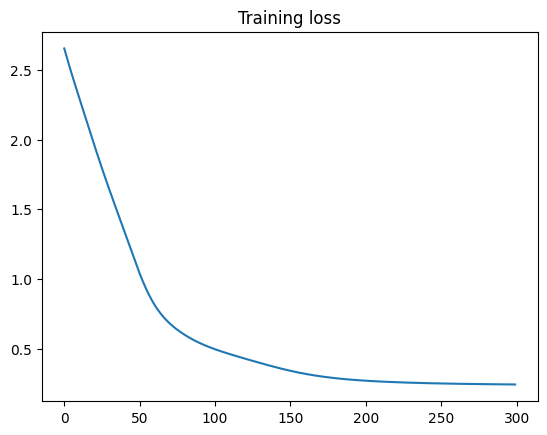

In [17]:
import matplotlib.pylab as plt

# define the neural network architecture
class W2WCBow(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
        self.linear = torch.nn.Linear(in_features=p, out_features=d, bias = False)

    def forward(self, x):
        e = self.embedding(x)
        e = e.mean(axis = 1)
        z = self.linear(e)
        return z
    
# define an instande of the model class
w2w_cbow = W2WCBow()
w2w_cbow(torch.LongTensor(X))

# define an optimizer and loss
optimizer = torch.optim.Adam(lr = 0.015, params = w2w_cbow.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
epochs = 300
for epoch in range(epochs):
    w2w_cbow.train()
    scores = w2w_cbow(torch.tensor(X))
    batch_loss = loss_fn(scores, torch.tensor(y))
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    losses.append(batch_loss.detach().numpy())

# visualize the training loss  
plt.plot(losses)
plt.title("Training loss")
plt.show()

Once training is finished, it makes sense to use center word vectors $\boldsymbol{V}$ as embeddings for our words. However, one may also experiment and can use feature word vectors $\boldsymbol{W}$ or the average vectors of both matrices. Our example is too small to produce high quality embeddings. However if you take a look at the cosine similarity matrix below, you can observe that, e.g., the model learned "vanilla" has a similar meaning to "strawberry" or "berlin" is similar to "paris" which makes sense, given our corpus information.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

word_embeddings = w2w_cbow.linear.weight.detach().numpy() #w2v_cbow.get_layer("center_vectors").get_weights()[0].transpose()
word_embeddings_df = pd.DataFrame(cosine_similarity(word_embeddings), columns = list(word2index.keys()), index = list(word2index.keys()))
word_embeddings_df

,i,love,vanilla,ice,cream,strawberry,the,capitol,of,germany,is,berlin,france,paris
i,1.000000,0.961937,0.197999,0.995542,0.998179,0.067533,0.997548,0.945962,-0.855104,-0.509024,0.947314,0.971648,0.512816,0.995319
love,0.961937,1.000000,0.304653,0.952148,0.976170,0.158178,0.942923,0.821565,-0.899451,-0.299850,0.992125,0.999172,0.359679,0.931105
vanilla,0.197999,0.304653,1.000000,0.107002,0.209035,0.987247,0.141539,0.072602,0.099214,-0.261378,0.202547,0.279205,-0.728460,0.163612
ice,0.995542,0.952148,0.107002,1.000000,0.993908,-0.026029,0.997498,0.946130,-0.885753,-0.473885,0.948428,0.963793,0.585395,0.992114
cream,0.998179,0.976170,0.209035,0.993908,1.000000,0.073567,0.992673,0.924981,-0.876413,-0.459991,0.964702,0.983883,0.493665,0.987758
strawberry,0.067533,0.158178,0.987247,-0.026029,0.073567,1.000000,0.014320,-0.024812,0.254549,-0.274170,0.049999,0.133640,-0.793768,0.041543
the,0.997548,0.942923,0.141539,0.997498,0.992673,0.014320,1.000000,0.962562,-0.850840,-0.532613,0.931172,0.955337,0.565637,0.998486
capitol,0.945962,0.821565,0.072602,0.946130,0.924981,-0.024812,0.962562,1.000000,-0.707832,-0.717903,0.797576,0.842482,0.626975,0.972874
of,-0.855104,-0.899451,0.099214,-0.885753,-0.876413,0.254549,-0.850840,-0.707832,1.000000,0.018435,-0.946694,-0.903088,-0.608204,-0.820652
germany,-0.509024,-0.299850,-0.261378,-0.473885,-0.459991,-0.274170,-0.532613,-0.717903,0.018435,1.000000,-0.214354,-0.323864,-0.241858,-0.577454


Note that words in the beginning and end of the sentences are ignored in our example which causes problems for such a small corpus but usually is not problematic for a large corpus. Given a large collection of documents, common embedding dimension $p$ are rather in the hundreds as in comparison to our example.

**How does the model learn similar meaning?**

The description from above explains the technical process, however, to understand how words with similar meaning get similar word vectors it may help to explain this in a more intuitive (and slightly technical) way. 

Let us take a look at the two sentences:

* I love vanilla ice cream
* I love strawberry ice cream

Using two words to the left and to the right, we would generate a vector which represents the surrounding "I, love" and "ice cream". Let us denote this vector by $\mathbf{w}$. This vector is going to be multiplied with every possible word vector $\mathbf{v}^{(I)}, \mathbf{v}^{(love)}, \mathbf{v}^{(vanilla)}, \mathbf{v}^{(strawberry)}, \mathbf{v}^{(ice)}, \mathbf{v}^{(cream)}$. Each multiplication is the dot product of $\mathbf{w}$ and one of the word vectors. The result is a real-valued number, if it helps denote it as a score. The higher the score the higher the probability prediction for the word. In our example the true categories are "vanilla" and "strawberry". This means after some training, the vectors for the corresponding words create high values for their dot products: $\mathbf{w}^T \mathbf{v}^{(vanilla)}$ and $\mathbf{w}^T \mathbf{v}^{(strawberry)}$. As the vector from the words in the window around the center words $\mathbf{w}$ is the same for both calculations. High values for both dot products can only be generated if $\mathbf{v}^{(vanilla)}$ and $\mathbf{v}^{(strawberry)}$ are similar...and this is how the magic happens.

Take a look below. For our trained model the aggregated vector for the window "I love --- ice cream", is given by:

In [19]:
feature_vector = w2w_cbow.embedding(torch.tensor(X[:1])).mean(axis = 1).detach().numpy()[0]
feature_vector

array([-1.5713732,  2.0375943, -1.5745722], dtype=float32)

The trained vanilla vector (from the center word matrix) is:

In [20]:
vanilla_vector = w2w_cbow.linear.weight[2].detach().numpy()
vanilla_vector

array([-1.9203664,  1.4191248, -1.5480498], dtype=float32)

The one for strawberry is:

In [21]:
strawberry_vector = w2w_cbow.linear.weight[5].detach().numpy()
strawberry_vector

array([-1.606981 ,  1.4069247, -1.8767095], dtype=float32)

All three vectors share similarity in sign and value. The scores (dot products) are:


In [22]:
feature_vector @ vanilla_vector

8.346729

In [23]:
feature_vector @ strawberry_vector

8.346923

If we change the similarity between the "vanilla" and "strawberry" representation by, e.g., changing the sign for the last number of the strawberry vector.

In [24]:
strawberry_vector[2] = -strawberry_vector[2]
strawberry_vector

array([-1.606981 ,  1.4069247,  1.8767095], dtype=float32)

The score for it is decreased which would reduce the probability prediction for seeing the word "strawberry", given the window "I love --- ice cream".

In [25]:
feature_vector @ strawberry_vector

2.4368942

This does not make sense as "vanilla" and "strawberry" are equally likely in our example. Thus, the more similar vector after training is more reasonable and more in line with the observed corpus.

### SG
The figure below visualizes the CBOW and the SG model. While CBOW uses words in the window arount the center word to predict the center word, SG uses the center word to predict words within the window size. Thus, the prediction simplifies to $P \left( w_l | w_i \right)$ for any feature word $w_l \in \lbrace w_{i-t}, w_{i-t+1}, ..., w_{i-1}, w_{i+1}, w_{i + t -1}, w_{i + t}  \rbrace$. As before, we use train two parameter matrices $\boldsymbol{W}, \boldsymbol{V}$, however, this time $\boldsymbol{W}$ represents word embeddings for center words and $\boldsymbol{V}$ word embeddings for context words.

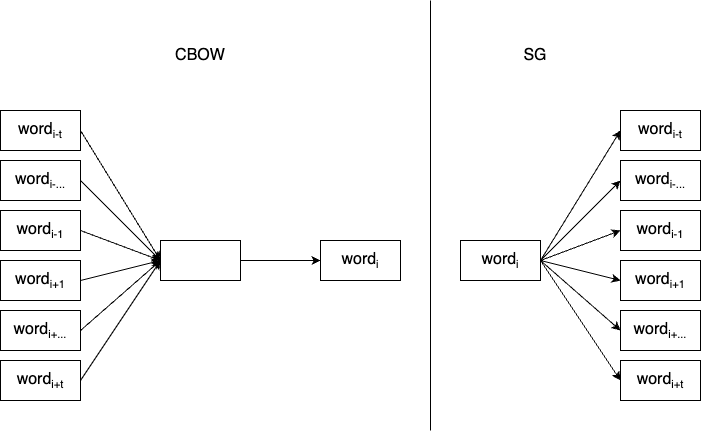

In [26]:
from IPython.display import Image
Image(filename='cbow_sg.png') 

Furthermore, training samples are reduced to one center word and one context word at a time (note this could also be transformed to a multi-label classifiction which should lead to the same or very similar results). Besides these differences, the training process is rather similar. First, we build training samples:

In [27]:
# number of terms in the lexicon
d = len(word2index.keys())
# embedding dimension
p = 3

# context length
k = 2
context_indices = [j for j in range(-k, k+1) if j != 0]

# generate training samples
sample_words = []
samples = []
for doc in corpus:
    for i in range(k, len(doc) - k):
        center_word = doc[i]
        center_word_idx = word2index[doc[i]]
        context_words = [doc[i + idx] for idx in context_indices]
        context_word_idx = [word2index[doc[i + idx]] for idx in context_indices]
        for context, context_word in zip(context_word_idx, context_words):
            sample_words.append((center_word, context_word))
            samples.append((center_word_idx, context))

print("This is how the training samples look like:")
print(sample_words)
print("")
print("This is how the training samples information is provided:")
print(samples)

This is how the training samples look like:
[('vanilla', 'i'), ('vanilla', 'love'), ('vanilla', 'ice'), ('vanilla', 'cream'), ('strawberry', 'i'), ('strawberry', 'love'), ('strawberry', 'ice'), ('strawberry', 'cream'), ('of', 'the'), ('of', 'capitol'), ('of', 'germany'), ('of', 'is'), ('germany', 'capitol'), ('germany', 'of'), ('germany', 'is'), ('germany', 'berlin'), ('of', 'the'), ('of', 'capitol'), ('of', 'france'), ('of', 'is'), ('france', 'capitol'), ('france', 'of'), ('france', 'is'), ('france', 'paris')]

This is how the training samples information is provided:
[(2, 0), (2, 1), (2, 3), (2, 4), (5, 0), (5, 1), (5, 3), (5, 4), (8, 6), (8, 7), (8, 9), (8, 10), (9, 7), (9, 8), (9, 10), (9, 11), (8, 6), (8, 7), (8, 12), (8, 10), (12, 7), (12, 8), (12, 10), (12, 13)]


Next, we prepare the target labels and input features:

In [28]:
# prepare training examples for a neural network
X = [sample[0] for sample in samples]
y = [sample[1] for sample in samples]
#y_one_hot = tf.keras.utils.to_categorical(y, num_classes = d)

print("Input for the neural network:")
print(X)
print("")
print("Target values for the neural network:")
print(y)

Input for the neural network:
[2, 2, 2, 2, 5, 5, 5, 5, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 12, 12, 12, 12]

Target values for the neural network:
[0, 1, 3, 4, 0, 1, 3, 4, 6, 7, 9, 10, 7, 8, 10, 11, 6, 7, 12, 10, 7, 8, 10, 13]


Define and train the neural network.

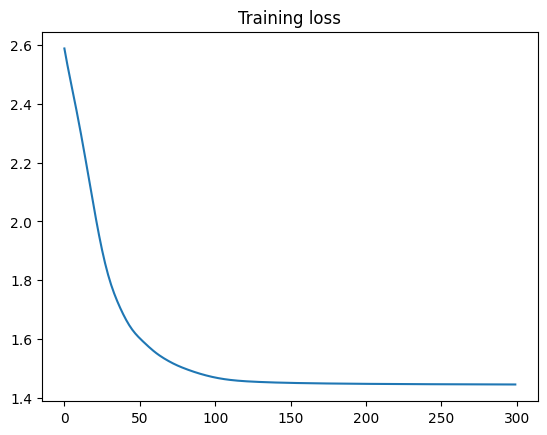

In [29]:
# define the neural network architecture
class W2WSG(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
        self.linear = torch.nn.Linear(in_features=p, out_features=d, bias = False)

    def forward(self, x):
        e = self.embedding(x)
        z = self.linear(e)
        return z
    
# define an instande of the model class
w2w_sg = W2WSG()

# define an optimizer and loss
optimizer = torch.optim.Adam(lr = 0.02, params = w2w_sg.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
epochs = 300
for epoch in range(epochs):
    w2w_sg.train()
    scores = w2w_sg(torch.tensor(X))
    batch_loss = loss_fn(scores, torch.tensor(y))
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    losses.append(batch_loss.detach().numpy())

# visualize the training loss  
plt.plot(losses)
plt.title("Training loss")
plt.show()

In [30]:
word_embeddings = w2w_sg.linear.weight.detach().numpy()
word_embeddings_df = pd.DataFrame(cosine_similarity(word_embeddings), columns = list(word2index.keys()), index = list(word2index.keys()))
word_embeddings_df

,i,love,vanilla,ice,cream,strawberry,the,capitol,of,germany,is,berlin,france,paris
i,1.000000,0.995822,0.189745,0.997016,0.990765,0.172196,-0.022980,-0.648640,-0.799567,-0.048529,-0.648566,-0.687712,0.004007,0.125947
love,0.995822,1.000000,0.225736,0.989086,0.988430,0.207422,0.062439,-0.637128,-0.835324,0.041754,-0.637047,-0.665759,0.095028,0.044758
vanilla,0.189745,0.225736,1.000000,0.114138,0.075841,0.999775,0.053789,-0.760229,0.052901,0.248181,-0.760239,0.576215,0.333026,0.072231
ice,0.997016,0.989086,0.114138,1.000000,0.995748,0.096524,-0.038248,-0.601415,-0.807009,-0.078859,-0.601339,-0.739646,-0.032061,0.132541
cream,0.990765,0.988430,0.075841,0.995748,1.000000,0.057254,0.043367,-0.539475,-0.857134,-0.007621,-0.539392,-0.770497,0.034052,0.046784
strawberry,0.172196,0.207422,0.999775,0.096524,0.057254,1.000000,0.042918,-0.755465,0.074060,0.238794,-0.755477,0.591647,0.323219,0.081555
the,-0.022980,0.062439,0.053789,-0.038248,0.043367,0.042918,1.000000,0.373338,-0.531405,0.978500,0.373417,-0.036079,0.959039,-0.988792
capitol,-0.648640,-0.637128,-0.760229,-0.601415,-0.539475,-0.755465,0.373338,1.000000,0.159401,0.244632,1.000000,-0.058678,0.151992,-0.507656
of,-0.799567,-0.835324,0.052901,-0.807009,-0.857134,0.074060,-0.531405,0.159401,1.000000,-0.449438,0.159290,0.753217,-0.462699,0.467641
germany,-0.048529,0.041754,0.248181,-0.078859,-0.007621,0.238794,0.978500,0.244632,-0.449438,1.000000,0.244701,0.130790,0.995452,-0.948160


### Practical considerations

CBOW aggregates context by summing or averaging context word vectors. This has a smoothing effect which may be helpful for smaller data sets. On the other side, it does not take full advantage of granular text information. As a consequence, it can be beneficial to use CBOW for smaller corpora and SG for larger ones. The embedding dimension is an important hyperparameter for the model. Choosing higher values may improve the understanding of similarity, while, at the same time, more data is needed to learn this. Common choices for larger and pre-trained models are in the range $[100, 300]$, however, sometimes embedding sizes go even higher. Another hyperparameter is the window size of the context. Common choices are between $5$ and $10$. Very frequent words can dominate the training of word embeddings. A common technique is to down-sample these words or even completely ignore them. At the same time words which appear very rarely may also be ignored because general relationships are hard to identify. Furthermore, training the model as a common multi-class classification problem can become cumbersome as the target dimension is equal to the number unique terms in the corpus. In practice, the model is usually trained by hierarchical softmax or negative sampling. This is beyond the scope of this course which is about the intuition how similar word embeddings are created for words with similar meaning.

## Working with word vectors

Once a Word2Vec model has been trained, we can generate numerical representations of words. An important side note is that a corpus usually is preprocessed before the model is trained. One central aspect of preprocessing is tokenization, i.e., the way each text is split into tokens which build the basis for creating a lexicon. Finally, each token in the lexicon will be mapped to a word embedding during the training process. This means, if we use, e.g., lower cases only, the word "Germany" will have no embedding because it is represented by the token "germany" after preprocessing. Consequently, if we process text in a different way than it has been done before training the model, we will receive many unknown token errors when we want to generate word embeddings. If we train our own model, this should be no problem because we can use the same tokenizer for handling text data after model training. However, if we use a pre-trained model and its embeddings, this may become a ciritical issue.

### Common usage

Nevertheless, let us start with a popular pre-trained model and its word embeddings: the [Google News embeddings](https://code.google.com/archive/p/word2vec/). They have been trained using the Google News dataset which includes about 100 billion words. The resulting model comes along with 300 dimensional vectors for 3 million words and phrases. What can we do with these vectors? The following common things come into mind:

* examine word similarities
* examine word analogies
* determine document embeddings
* visualize word embeddings

To determine word similarities, we compute a vector based similarity measure. The most popular choice in the natural language processing domain is the cosine similarity which has been presented in an earlier chapter of this book. For instance, the cell below shows the top ten similar words to the word "crisis":

In [31]:
from gensim.models import KeyedVectors

google_word_vectors = KeyedVectors.load_word2vec_format("../language_models/GoogleNews-vectors-negative300.bin.gz", binary = True)
google_word_vectors.most_similar(positive = "crisis")

[('crises', 0.7838959693908691),
 ('turmoil', 0.6912833452224731),
 ('meltdown', 0.6789990067481995),
 ('credit_crunch', 0.6228187084197998),
 ('crisis.The', 0.6024228930473328),
 ('recession', 0.5982968211174011),
 ('downturn', 0.5976395010948181),
 ('subprime_mortgage_crisis', 0.5934383869171143),
 ('economic_downturn', 0.5829673409461975),
 ('liquidity_crunch', 0.5580255389213562)]

We observe cosine similarities in the range between $0.53$ and $0.63$. This brings up the question about the actual range of cosine similarities for all word embeddings. Due to the immense amount of words, we sample 10,000 words from the lexicon and determine their pairwise cosine similarities. The histogram below demonstrates that similarities seem to be roughly in the range $[-0.25, 0.80]$, even though values in the interval $[-1, 1]$ would be possible. This gives us a better understanding of common similarity levels for word pairs are. 

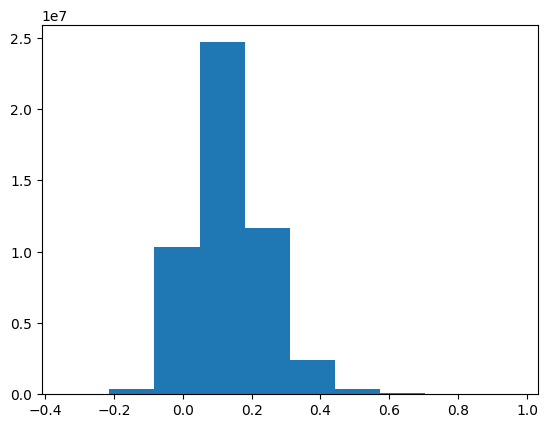

In [32]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity

# draw 10000 random vectors and determine their pairwise similarities to get an idea about the similarity range
rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(google_word_vectors), size=10000, replace=False)
pairwise_similarities = cosine_similarity(google_word_vectors[rnd_idx]) 
pairwise_similarities_flat = pairwise_similarities[np.tril_indices(pairwise_similarities.shape[0], k = -1)]
plt.hist(pairwise_similarities_flat)
plt.show()

We also observe n-grams are included in the list of similar words. Usually, not all possible n-grams are taken into account, only very common combinations such as "New York". To identify common n-grams, one can, e.g., determine a score as suggested by [Mikolov et al. (2013)](https://arxiv.org/pdf/1310.4546):

$$
score(w_i, w_j) = \frac{count(w_i, w_j) - \delta}{count(w_i) \cdot count(w_j)}
$$

With $count(w_i, w_j), count(w_i), count(w_j)$ representing the number of co-occurrences for word pair $i,j$ and individual occurrences, respectively, and, $\delta$ a discounting coefficient. If a score exceeds a user-defined threshold, the pair is considered as a bi-gram. Repeating this counting process is also able to reveal n-grams of higher order.

The next impressive aspect of word embeddings is that we can use vector calculus to examine similarities and dissimilarities between words. The most popular example is the word analogy of "woman" to "man" which should be similar to "queen" and "king". Given the vectors $\boldsymbol{w}^{(woman)}, \boldsymbol{w}^{(man)}, \boldsymbol{w}^{(queen)}, \boldsymbol{w}^{(king)}$, we can calculate the differences $\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)}$ and $\boldsymbol{w}^{(queen)} - \boldsymbol{w}^{(king)}$. If the relation of woman to man is similar as the relation of queen to king, we should get:

$$
\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)} \approx \boldsymbol{w}^{(queen)} - \boldsymbol{w}^{(king)} 
$$

thus, 

$$
\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)} + \boldsymbol{w}^{(king)} 
$$

should be most similar to 

$$
\boldsymbol{w}^{(queen)}
$$

Let us find out:

In [33]:
google_word_vectors.similar_by_vector(google_word_vectors["woman"] - google_word_vectors["man"] + google_word_vectors["king"])

[('king', 0.8449392318725586),
 ('queen', 0.7300516366958618),
 ('monarch', 0.6454660296440125),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676948547363),
 ('prince', 0.5777117609977722),
 ('kings', 0.5613663792610168),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

Tadaa! This seems to work pretty good. Note, the calculation can also be done by the most_similar method, positive are the vectors with a positive sign, negative the ones with a negative sign:

In [34]:
google_word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

If we can calculate with words, we can also average and sum word vectors. For instance, we can split a sentence into words and sum or average its word vectors to derive a sentence embedding. 

In [35]:
import pandas as pd

print("Tokenized sentences:")
print(f"{corpus} \n")
sentence_embeddings = [google_word_vectors.get_mean_vector(sentence) for sentence in corpus]
cosine_similarity_matrix = np.round(cosine_similarity(np.array(sentence_embeddings)), 4)
print("Pairwise cosine similarities:")
pd.DataFrame(cosine_similarity_matrix, index = [f"s{i+1}" for i in range(4)], columns = [f"s{i+1}" for i in range(4)])

Tokenized sentences:
[['i', 'love', 'vanilla', 'ice', 'cream'], ['i', 'love', 'strawberry', 'ice', 'cream'], ['the', 'capitol', 'of', 'germany', 'is', 'berlin'], ['the', 'capitol', 'of', 'france', 'is', 'paris']] 

Pairwise cosine similarities:


,s1,s2,s3,s4
s1,1.0000,0.9274,0.3028,0.3652
s2,0.9274,1.0000,0.3039,0.3514
s3,0.3028,0.3039,1.0000,0.8732
s4,0.3652,0.3514,0.8732,1.0000


Furthermore, we can build topic vectors which are calculated as the average of individual word vectors which represent a similar content. 

In [36]:
topic_words = ["environmental", "social", "governance"]
google_word_vectors.most_similar(topic_words)

[('ecological', 0.6291204690933228),
 ('corporate_governance_ESG', 0.6060682535171509),
 ('governance_ESG_issues', 0.6004064679145813),
 ('sustainablity', 0.5869180560112),
 ('environmental_sustainability', 0.5842981338500977),
 ('governance_ESG_factors', 0.5816299319267273),
 ('governance_ESG', 0.57416170835495),
 ('sustainability', 0.561872124671936),
 ('socio_economic', 0.5555124282836914),
 ('Melissa_McEver_covers', 0.5459955334663391)]

The only thing which is a little unfortunate is that we are not able to visualize how close certain word vectors are to others. This can be overcome by combining dimensionality reduction techniques with word embeddings. Different models can be used for dimensionality reduction. In general, dimensionality reduction tries to find lower dimensional representations of the original word vectors which keep as much of the original behavior as possible. 

*What dimensionality reduction techniques do*

We dot not discuss in this course how these methods work, however, the figure below demonstrates the functionality. In the left are observations from a fictional data set with 100 observations of two variables $x_1, x_2$. Three arbitrary observations are marked by the colors red, blue and green. Green and red are more close to each other than to blue. Thus, according to euclidean distance, green and red are more similar to each other than to blue. In the right, we observe a single variable which has been created out of the original two variables using a dimensionality reduction technique. Also in this one dimensional representation, the red and green observation are more close to each other than to the blue observations. Thus, this characteristic is not the same as before, but, kept as similar as possible. 

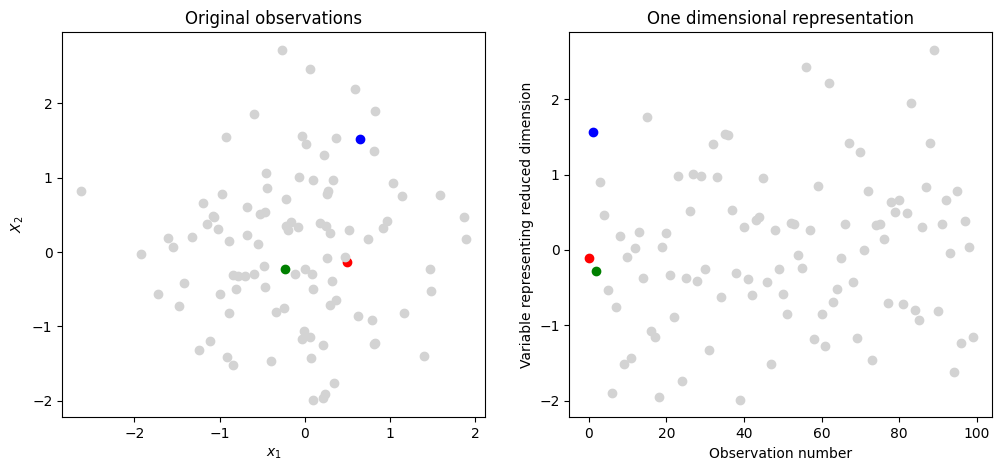

In [37]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

np.random.seed(42)
X = np.random.normal(size = 200).reshape(100, 2)
pca = PCA(n_components=1)
x = pca.fit_transform(X)
colors = {i: "lightgray" for i in range(X.shape[0])}
colors[0] = "red"
colors[1] = "blue"
colors[2] = "green"

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
for i in range(X.shape[0]):
    axs[0].scatter(X[i, 0], X[i, 1], c = colors[i])
    axs[1].scatter(i, x[i], c = colors[i])
axs[0].set_title("Original observations")
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$X_2$")
axs[1].set_title("One dimensional representation")
axs[1].set_xlabel(r"Observation number")
axs[1].set_ylabel(r"Variable representing reduced dimension")
plt.show()

Below, we train the umap reduction model to a sample of 100,000 word vectors. 

In [38]:
import umap
import pickle

try:
    with open("../language_models/w2v_10K/dim_reducer_google.pkl", "rb") as handle:
        dim_reducer = pickle.load(handle)
except:
    print("Train dimensionality reducer first...")
    dim_reducer = umap.UMAP(n_components=2, metric = "cosine")
    rnd_idx = rng.choice(len(google_word_vectors), size=100000, replace=False)
    dim_reducer.fit(google_word_vectors[rnd_idx])
    with open("../language_models/w2v_10K/dim_reducer_google.pkl", 'wb') as handle:
        pickle.dump(dim_reducer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train dimensionality reducer first...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Now, we combine these techniques and plot two dimensional representations for similar and random words. In the example below, we look for the $20$ most similar words of the word "crisis". We generate two dimensional representations for the corresponding word vectors by transforming the original $300$ dimensional vectors with the umap dimensionality reduction model. The same thing is done for $100$ randomly selected words. The resulting vectors can be viszalized in the scatter plot below. 

In [39]:
import plotly.express as px

def plot_similar_words_2d(word, n_words, word_vectors, reducer, rnd_state = 42):
    most_sim_words = word_vectors.most_similar(word, topn = n_words)
    positive_words = word + [element[0] for element in most_sim_words]
    positive_words_2d = reducer.transform(word_vectors[positive_words])
    positive_words_2d_df = pd.DataFrame(positive_words_2d, index = positive_words, columns = ["u1", "u2"])
    positive_words_2d_df.loc[:, "category"] = "positive"

    positive_indices = [word_vectors.key_to_index[positive_word] for positive_word in positive_words]
    negative_indices = [i for i in range(len(word_vectors)) if not(i in positive_indices)]
    np.random.seed(rnd_state)
    negative_words_indices = np.random.choice(negative_indices, 5 * n_words, replace = False).tolist()
    negative_words = [word_vectors.index_to_key[negative_words_index] for negative_words_index in negative_words_indices]
    negative_words_2d = reducer.transform(word_vectors[negative_words_indices])
    negative_words_2d_df = pd.DataFrame(negative_words_2d, index = negative_words, columns = ["u1", "u2"])
    negative_words_2d_df.loc[:, "category"] = "negative"

    words_2d = pd.concat((positive_words_2d_df, negative_words_2d_df))

    fig = px.scatter(words_2d, x = "u1", y = "u2", color = "category", hover_name = words_2d.index, width = 800, height = 600, title = f"Similar and random words for the word(s): {word} in 2D")
    return fig

fig = plot_similar_words_2d(["crisis"], 20, google_word_vectors, dim_reducer)
fig.show()

### Performance evaluation for Word2Vec models

Two popular choices for evaluating the quality of word vectors are predefined analogy tasks as well as similarity tasks. The latter compute the correlation of pairwise word similarities made by humans and the ones derived by word embeddings. See below some examples for these tasks. In addition, another way to examine the quality of word embeddings is to use them for common natural language processing tasks and quantify the outcome. One of the most common sets of tasks is provided by the [General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/). However, if we are interested in domain specific performance, these considerations may not be most important to us. Given we train our word vectors mostly on, e.g., financial documents, it may be not surprising that these word embeddings may lack in their usage for general language understanding. However, they might be better in the representation of domain specific content. 

In [40]:
from gensim.test.utils import datapath

with open(datapath("questions-words.txt"), "r") as file:
    lines = file.readlines()

print("-"*50)
print("Examples for word analogy tasks:")
print("-"*50)

rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(lines), size=5, replace=False)
for i, line in enumerate(lines):
    if i in rnd_idx:
        print(line)

with open(datapath("simlex999.txt"), "r") as file:
    lines = file.readlines()

print("-"*50)
print("Examples for human similarity:")
print("-"*50)
rnd_idx = rng.choice(len(lines), size=5, replace=False)
for i, line in enumerate(lines):
    if i in rnd_idx:
        print(line)

--------------------------------------------------
Examples for word analogy tasks:
--------------------------------------------------
Chisinau Moldova Ljubljana Slovenia

father mother son daughter

he she father mother

smart smartest quick quickest

Korea Korean Netherlands Dutch

--------------------------------------------------
Examples for human similarity:
--------------------------------------------------
unhappy	mad	5.95

whiskey	champagne	5.33

liquor	century	0.4

gun	fur	0.3

attach	join	7.75



### Domain specific word embeddings

If we are in need of domain specific word embeddings, we need to train a model by ourselves. Usually, this comes along with certain shortcomings. First, domain specific corpora usually are smaller which can have a negative impact on embedding quality as the vectors are trained on a lower number of samples. Second, the training of language models can come along with high computational needs and costs. While this usually is no problem for Word2Vec, it certainly is for today's state of the art language models.

For demonstrational purposes, let us compare the embeddings from the Google News corpus with embeddings that I trained. Our model has been trained on a corpus which includes around 50,000 annual 10-K form reports from US stock market companies between the years of 2002 until 2024. Each of the tokens in our lexicon is represented by a  $256$ dimensional vector. We include 2-gram and 3-gram phrases as well.

In [41]:
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load("../language_models/w2v_10K/w2v_tenks_simple_preprocess.wv")
word_vectors.most_similar(positive = "crisis")

[('turmoil', 0.797111451625824),
 ('crises', 0.7884368300437927),
 ('recession', 0.7787991166114807),
 ('downturn', 0.7080113887786865),
 ('pandemic', 0.6979981660842896),
 ('covid_pandemic', 0.6935710906982422),
 ('dislocation', 0.6893791556358337),
 ('covid_outbreak', 0.6854550838470459),
 ('coronavirus_pandemic', 0.6810986995697021),
 ('unprecedented', 0.6780808568000793)]

Even though the text data spans over a longer history which also includes the subprime mortgage crisis, the word embedding seems to be closely connected to the covid crisis. However, the first words seem to make perfect sense in a more general understanding of a crisis period. The range of similarities is not very different to the Google News embeddings. This may be impacted by the similar dimensionality of embeddings. 

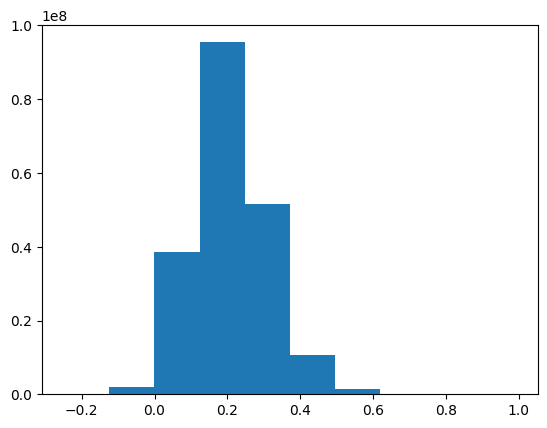

In [42]:
from numpy.random import default_rng
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity

# draw 10000 random vectors and determine their pairwise similarities to get an idea about the similarity range
rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(word_vectors), size=20000, replace=False)
pairwise_similarities = cosine_similarity(word_vectors[rnd_idx]) 
pairwise_similarities_flat = pairwise_similarities[np.tril_indices(pairwise_similarities.shape[0], k = -1)]
plt.hist(pairwise_similarities_flat)
plt.show()

Out of curiosity, let us take a look at the analogy task from before.

In [43]:
word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])

[('newman', 0.5788643956184387),
 ('rosa', 0.5675449967384338),
 ('vincent', 0.558138906955719),
 ('ginny', 0.5542693138122559),
 ('brown', 0.5492302775382996),
 ('graham', 0.5474479794502258),
 ('dr_schneier', 0.5460469126701355),
 ('love', 0.5424930453300476),
 ('hoffman', 0.5422849655151367),
 ('freeman', 0.5407364368438721)]

The domain specific vectors fail w.r.t. to this task. This is no big surprise, because it seems very unlikely that royal relationships are often discussed in financial reports. Similar words to the environmental, social and governance topic make perfect sense. 

In [44]:
topic_words = ["environmental", "social", "governance"]
word_vectors.most_similar(topic_words)

[('esg', 0.6639025807380676),
 ('sustainability', 0.6402939558029175),
 ('stewardship', 0.6179935336112976),
 ('workplace', 0.5966511964797974),
 ('ehs', 0.5817580819129944),
 ('cybersecurity', 0.5638284683227539),
 ('ethical', 0.5631417632102966),
 ('citizenship', 0.5618754029273987),
 ('societal', 0.5606372952461243),
 ('diversity_and_inclusion', 0.5588008165359497)]

Similar words to the environmental, social and governance topic make perfect sense. Let us take a look at them in the reduced two dimensional representation.

In [51]:
import umap
import pickle

try:
    with open("../language_models/w2v_10K/dim_reducer_10K.pkl", "rb") as handle:
        dim_reducer = pickle.load(handle)
except:
    print("Train dimensionality reducer first...")
    dim_reducer = umap.UMAP(n_components=2, metric = "cosine")
    dim_reducer.fit(word_vectors.get_normed_vectors())
    with open("../language_models/w2v_10K/dim_reducer_10K.pkl", 'wb') as handle:
        pickle.dump(dim_reducer, handle, protocol=pickle.HIGHEST_PROTOCOL)

fig = plot_similar_words_2d(["crisis"], 10, word_vectors, dim_reducer)
fig.show()

This can also be a coinsidence, however, the similar words are closer to each other than in comparison to the Google News model. 

## Identifying climate talk in annual reports with Word2Vec

In a previous chapter, we identified climate change related words by term frequencies of tokens in climate change white papers that are weighted with inverse-document-frequencies of 10-K annual reports from US stock market listed companies. The word cloud below exhibits the tokens. The larger the token, the higher its term-frequency inverse-document-frequency. We observe a set of tokens which seems to include climate change related tokens, however, also includes tokens such as "et al" or "figure" which are obviously not strongly related to the climate change topic. Furthermore, very likely more token exist in the corpus which have similar meaning to these words and which can be important to identify climate talk of companies. So let's try to tackle these challenges by:

* Eliminate tokens not related to the climate change topic
* Find more tokens which are related to climate change

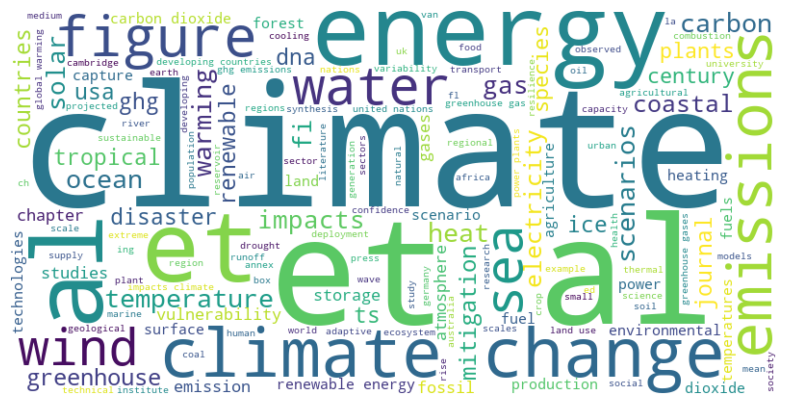

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

term_frequencies = pd.read_csv("../notebooks/2024/climate_disclosure/climate_change_vocabulary_wordloud.csv").set_index("Unnamed: 0").to_dict()["0"]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.show()

*Eliminate not related tokens*

To eliminate tokens which are not related to climate change (at least as good as possible), we group the vectors for each token in the cloud above by a clustering algorithm. Describing the algorithm is beyond the scope of this course, however, the task for every clustering algorithm is to build groups of observations which are similar to each other and not similar to members of other groups. For our task, this means the algorithm is supposed to group tokens (given their numerical representation) such that the meaning of the words in each group are similar but different to the meaning of words in other groups. Usually, one combines dimensionality reduction techniques with clustering, as the original vector size exposes the clustering technique to the curse of dimensionality. For instance, to visualize, the tokens and and groups of tokens (by color), we reduce the original dimension from 200 to 2. At the same time, the clustering has been done after a dimensionality reduction from 200 to 5. If you are not familiar with these techniques, you only need to know that, after the dimensionality reduction, the amount of numbers which is used to embed a word is reduced while at the same time, the relationships are as close as possible to the relationships in the original (higher) dimension.

In [54]:
import pandas as pd
from gensim.models import KeyedVectors
from numpy.random import default_rng
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

ccv = pd.read_csv("../notebooks/2024/climate_disclosure/climate_change_vocabulary_wordloud.csv")
ccv.columns = ["word", "tfidf_score"]

word_vectors = KeyedVectors.load("../language_models/w2v_10K/w2v_tenks_simple_preprocess.wv")
import hdbscan
import umap

# word with vector in model
ccv_words = [word for word in ccv.word.tolist() if word in word_vectors]

# corresponding word vectors
ccv_word_vectors = pd.DataFrame(word_vectors[ccv_words], index = ccv_words)


dim_reducer = umap.UMAP(n_components=5, metric = "cosine", random_state = 42)
dim_reducer.fit(ccv_word_vectors)
X = dim_reducer.transform(ccv_word_vectors)

hdbscan_model = hdbscan.HDBSCAN(min_samples=4)
hdbscan_model.fit(X)

labels = hdbscan_model.labels_

print("Tokens for each cluster:")
ccv_word_vector_clusters = pd.DataFrame(dict(word = ccv_words, label = labels))
for label, group in ccv_word_vector_clusters.groupby("label"):
    print("-"*100)
    print(label)
    print(group.word.tolist())

keep_ccv_words = ccv_word_vector_clusters[ccv_word_vector_clusters.label.isin([1, 4, 5, 6, 7])].word.tolist()
print("\n\nFinal list of tokens after removing words from clusters which have no strict relationship to the topic climate change:")
print("-"*120)
print(keep_ccv_words)

Tokens for each cluster:
----------------------------------------------------------------------------------------------------
-1
['fi', 'tropical', 'dna', 'ice', 'vulnerability', 'technologies', 'land', 'heating', 'air', 'sustainable', 'human', 'social', 'nations', 'oil', 'urban', 'box', 'geological', 'earth', 'wave', 'synthesis', 'example', 'sector', 'medium', 'resilience', 'health', 'sectors', 'reservoir', 'developing', 'small', 'population']
----------------------------------------------------------------------------------------------------
0
['energy', 'wind', 'solar', 'gas', 'electricity', 'renewable', 'plants', 'storage', 'fossil', 'production', 'power', 'fuel', 'fuels', 'natural', 'coal', 'transport', 'capacity', 'plant', 'generation', 'supply']
----------------------------------------------------------------------------------------------------
1
['sea', 'ocean', 'coastal', 'chapter', 'forest', 'agriculture', 'agricultural', 'crop', 'food', 'river', 'marine', 'runoff']
---------

If you hover over the data points below, you can identify the token. The color corresponds to the cluster in five dimension. After identification of the tokens per cluster, we only keep groups of tokens where the majority of tokens has a clear relationship to the topic climate change. If you take a look in the output of the cell above, you can eamine this process and the final (cleaned) climate change wordlist.

In [55]:
import plotly.express as px

dim_reducer = umap.UMAP(n_components=2, metric = "cosine", random_state = 42)
dim_reducer.fit(ccv_word_vectors)
U = dim_reducer.transform(ccv_word_vectors)

px.scatter(x = U[:, 0], y = U[:, 1], hover_name = ccv_word_vectors.index, color = labels)

*Identifying more climate change tokens*

Next, we use cosine similarity of these climate tokens to identify more tokens with a similar meaning. For each token, we search for the most similar tokens of the Word2Vec model which has been trained on the 10-K report corpus. While the original tokens are from climate white papers, the most similar tokens from the trained Word2Vec model are tokens which are used in similar ways in financial reports and may be even better suited for the identification of climate talk in annual reports. Specifically, for each token, we collect the 100 most similar tokens, however, we only keep tokens if their cosine similarity is larger then the 97.5\% quantile of all pairwise cosine similarities in the dictionary. The latter is estimated as shown a few cells above. We sample 20,000 tokens from the Word2Vec model, determine cosine similarities for all possible pair combinations and determine the empirical 97.5\% quantile. 

In [56]:
import numpy as np

word_sim_high = np.quantile(pairwise_similarities_flat, q = [0.975])[0]
ccv_sim_tokens = pd.DataFrame(columns = ["word", "cosine_sim"])

for term in keep_ccv_words:

    if len(term.split(" ")) == 1:
        most_sim_tokens = word_vectors.most_similar(term, topn = 100)
        sim_tokens_df = pd.DataFrame(most_sim_tokens )
        sim_tokens_df = sim_tokens_df[sim_tokens_df.iloc[:, 1] > word_sim_high]
    else:
        term_phrase = "_".join(term.split(" "))
        if term_phrase in word_vectors:
            most_sim_tokens = word_vectors.most_similar(term_phrase, topn = 100)
            sim_tokens_df = pd.DataFrame(most_sim_tokens )
            sim_tokens_df = sim_tokens_df[sim_tokens_df.iloc[:, 1] > word_sim_high] 
        else:
            most_sim_tokens = word_vectors.most_similar(term.split(" "), topn = 100)
            sim_tokens_df = pd.DataFrame(most_sim_tokens )
            sim_tokens_df = sim_tokens_df[sim_tokens_df.iloc[:, 1] > word_sim_high]

    sim_tokens_df.columns = ["word", "cosine_sim"]

    ccv_sim_tokens = pd.concat((ccv_sim_tokens, sim_tokens_df), ignore_index=True)

The cell below exhibits a two dimensional representation of the full climate change dictionary which is derived in this way. You can examine tokens by hovering over the points. While doing so, you may realize tokens appear which would not be identified if we try to create a word list without this model driven approach, e.g., "difficulty_in_predicting". However, if you understand the way Word2Vec is learning its numerical representations of words, tokens like this one may not be surprising anymore. Tokens within a certain window size around climate change related tokens or the token "difficulty_in_predicting" seem to be very similar which causes the similar numerical representation.

In [57]:
import umap
import plotly.express as px

ccv_words_full = keep_ccv_words + ccv_sim_tokens.word.tolist()
ccv_word_vectors = pd.DataFrame(word_vectors[ccv_words_full], index = ccv_words_full)

dim_reducer = umap.UMAP(n_components=2, metric = "cosine", random_state = 42)
dim_reducer.fit(ccv_word_vectors)
ccv_word_vectors_2d = pd.DataFrame(dim_reducer.transform(ccv_word_vectors), columns = ["u", "v"], index = ccv_word_vectors.index)

px.scatter(ccv_word_vectors_2d, x = "u", y = "v", hover_name = ccv_word_vectors_2d.index, title = "climate change tokens")

Now, let us compare what happens if we use these words as a measure for climate talk in annual reports. Similar to the research paper by [Sautner et al. (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3642508), we measure climate talk by the fraction of tokens from the extended climate change token list in an annual report, i.e., 

$$
cce = \frac{1}{T} \sum_{t=1}^T 1_{\lbrace t \in \text{climate dictionary} \rbrace}
$$

where $1_{\lbrace t \in \text{climate dictionary}}$ is an indicator function which is equal to 1 if token $t$ is in the climate word list and $T$ is the number of tokens in a document (in our analysis a document is an annual report). Similar to our analysis in the previous chapter, we calculate this measure for 30,840 10-K reports of 3,632 companies over the time period 2012 until 2024. Overall, the results are similar, yet, not the same. Below, we observe that the levels of climate talk measures by $cce$ do not vary much over time. 

In [61]:
import sqlite3
import pandas as pd
import matplotlib.pylab as plt

conn = sqlite3.connect("/Users/ralf/Library/Mobile Documents/com~apple~CloudDocs/Python/Eikon/collect_data_returns_and_fundamentals/us_data.sqlite")
company_info = pd.read_sql("Select * From general_company_information;", conn)
conn.close()
company_info = company_info.rename({"TRBC Economic Sector Name": "Sector"}, axis = 1)

indices_to_drop = []
for ric, df_tmp in company_info.groupby("Instrument"):
    indices_to_drop.extend(list(df_tmp.replace("", pd.NA).isna().sum(axis = 1).argsort().index[1:]))
company_info.drop(indices_to_drop, axis = 0, inplace = True)
company_info = company_info[~company_info["CIK Number"].isna()]
company_info["CIK Number"] = company_info["CIK Number"].astype(int).apply(lambda x: str(x).zfill(10))
company_info.reset_index(drop = True, inplace = True)

conn = sqlite3.connect("/Users/ralf/Library/Mobile Documents/com~apple~CloudDocs/Python/Eikon/collect_data_returns_and_fundamentals/us_data.sqlite")
cce_w2v = pd.read_sql("Select RIC, filingDate, cce_w2v From cce_w2v;", conn)
conn.close()

cce_w2v = pd.merge(cce_w2v, company_info.get(["Instrument", "Sector"]), left_on = "RIC", right_on = "Instrument", how = "left")
cce_w2v.loc[:, "year"] = pd.to_datetime(cce_w2v['filingDate']).dt.to_period("Y")
cce_w2v.get(["year", "cce_w2v"]).boxplot(column = "cce_w2v", by = "year", figsize = (12, 6))
plt.show()

DatabaseError: Execution failed on sql 'Select RIC, filingDate, cce_w2v From cce_w2v;': no such table: cce_w2v

As before, the picture changes once we examine $cce$ per sector. In comparison to the result before, it seems that the $cce$ measure is less dispersed and has less outliers. 

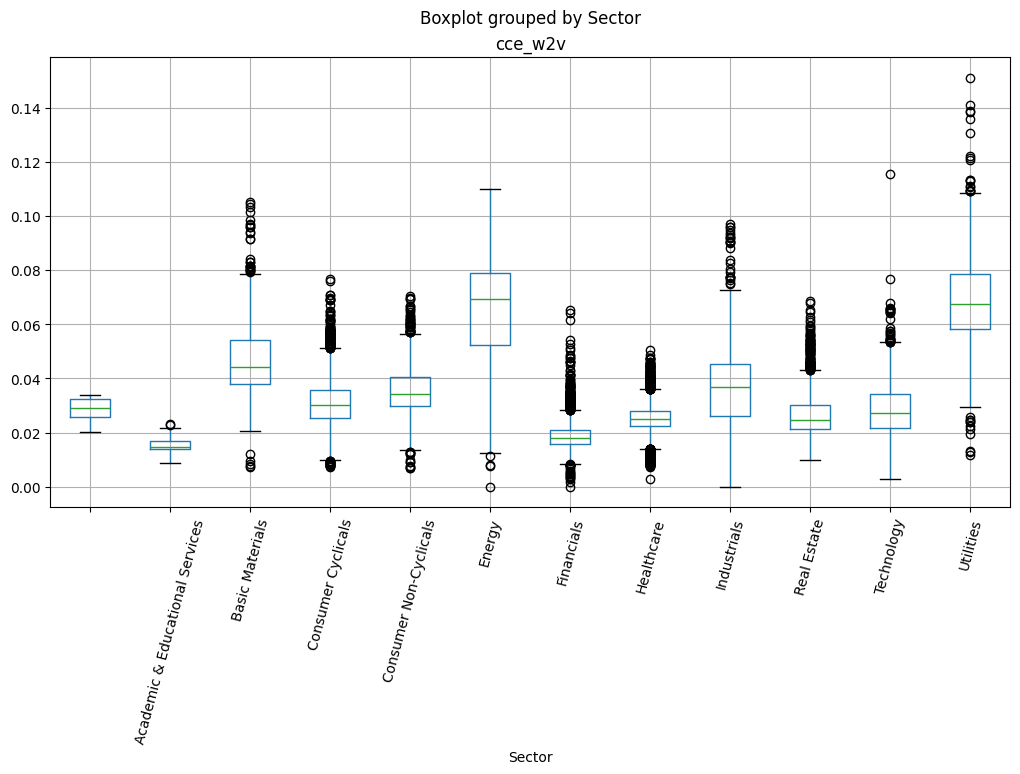

In [ ]:
cce_w2v.get(["Sector", "cce_w2v"]).boxplot(column = "cce_w2v", by = "Sector", figsize = (12, 6), rot = 75)
plt.show()

If we take a look at the two different measures in a scatter plot for all reports, we observe the rather high similarity between both climate talk measures. The corresponding spearman correlation is approximately 70\%. In my opinion, this is reasonable and interesting at the same time. Both approaches use very different methods, however, the logic behind both approaches is similar. 

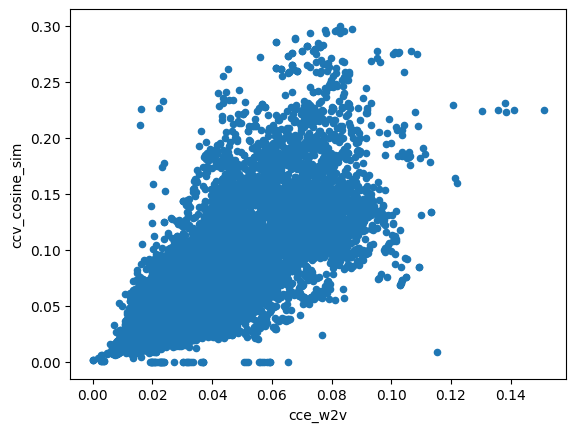

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("/Users/ralf/Library/Mobile Documents/com~apple~CloudDocs/Python/Eikon/collect_data_returns_and_fundamentals/us_data.sqlite")
ccv_tfidf = pd.read_sql("Select RIC, filingDate, ccv_cosine_sim From ccv_sim_tenks;", conn)
conn.close()

compare_cctalk = pd.merge(cce_w2v, ccv_tfidf, on = ["RIC", "filingDate"])
compare_cctalk.plot.scatter(x = "cce_w2v", y = "ccv_cosine_sim")
plt.show()

## Outlook 

In this chapter, we learned how meaningful word representations can be trained. For many applications, we are in need of meaningful representations for full documents or at least parts of them. For instance, a numerical representation of a financial news headline may be used to analyze stock market reactions to financial news. We have seen in this chapter that such representation can be derived by summing or averaging numerical representations for each word in a document. However, this approach may be not granular enough, especially for longer documents with different contents. Furthermore, it gives identical weights to each part of the document. Both shortcomings are tackled by other approaches. The first is how to derive more granular embeddings for documents and will be discussed in the next section. Afterwards, we head towards the self-attention mechanism of modern language models which deals among others with the challenge to focus on the important parts of documents.